In [1]:
from collections import Counter
from scipy.special import softmax
from torch_geometric.transforms import ToUndirected
from torch.optim.lr_scheduler import ExponentialLR
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.nn import BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler
import uproot
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
import awkward as ak
import random
random.seed(42)

In [2]:
uproot.__version__

'5.3.9'

In [3]:
file = uproot.open("/home/mxg1065/MyxAODAnalysis_super3D.outputs.root")

In [4]:
file.keys()

['analysis;1']

In [5]:
tree = file['analysis']
branches = tree.arrays()
type(branches)

awkward.highlevel.Array

In [6]:
print(tree.keys())  # variables per event

['RunNumber', 'EventNumber', 'cell_eta', 'cell_phi', 'cell_x', 'cell_y', 'cell_z', 'cell_subCalo', 'cell_sampling', 'cell_size', 'cell_hashID', 'neighbor', 'seedCell_id', 'cell_e', 'cell_noiseSigma', 'cell_SNR', 'cell_time', 'cell_weight', 'cell_truth', 'cell_truth_indices', 'cell_shared_indices', 'cell_cluster_index', 'cluster_to_cell_indices', 'cluster_to_cell_weights', 'cell_to_cluster_e', 'cell_to_cluster_eta', 'cell_to_cluster_phi', 'cluster_eta', 'cluster_phi', 'cluster_e', 'cellsNo_cluster', 'clustersNo_event', 'jetEnergyWtdTimeAve', 'jetEta', 'jetPhi', 'jetE', 'jetPt', 'jetNumberPerEvent', 'cellIndices_per_jet']


In [7]:
len(branches['cluster_to_cell_indices'][0])

839

# Preparing data with required features for 100 events

In [8]:
# (100, 187652) 100 events and 187652 cells
cell_coordinate_x = np.array(branches['cell_x'])
cell_coordinate_y = np.array(branches['cell_y'])  # (100, 187652)
cell_coordinate_z = np.array(branches['cell_z'])  # (100, 187652)
cell_eta = np.array(branches['cell_eta'])  # (100, 187652)
cell_phi = np.array(branches['cell_phi'])  # (100, 187652)
cell_subCalo = np.array(branches['cell_subCalo'])  # (100, 187652)
cell_sampling = np.array(branches['cell_sampling'])  # (100, 187652)
cell_weight = np.array(branches['cell_weight'])  # (100, 187652)
cell_truth = np.array(branches['cell_truth'])  # (100, 187652)
cell_to_cluster_e = np.array(branches['cell_to_cluster_e'])  # (100, 187652)
cell_noiseSigma = np.array(branches['cell_noiseSigma'])  # (100, 187652)
cell_SNR = np.array(branches['cell_SNR'])  # (100, 187652)
cell_time = np.array(branches['cell_time'])  # (100, 187652)
# 100 events but different number of entries per event
cellsNo_cluster = branches['cellsNo_cluster']
# Not a np array due to irregular subarray lengths
clustersNo_event = np.array(branches['clustersNo_event'])  # (100, 1)
cell_to_cluster_index = np.array(
    branches['cell_cluster_index'])  # (100, 187652)
cell_e = np.array(branches['cell_e'])  # (100, 187652)
# Not a np array due to irregular subarray lengths
cluster_to_cell_indices = branches['cluster_to_cell_indices']
# 100 events, but with different entries per event.
# Not a np array due to irregular subarray lengths
neighbor = branches['neighbor']
# 100 events but with a repeating pattern of
# [[63, 1, 26496, 26497, 26498, 26499, 64, 26751, 127, 26500, 65, 448], ...]...

In [9]:
num_of_events = len(cell_to_cluster_index)
print(num_of_events)

100


In [10]:
# Initialize a list of data, storing three features per event
data = {}

for i in range(num_of_events):
    data[f"data_{i}"] = np.concatenate((np.expand_dims(cell_SNR[i], axis=1),
                                        np.expand_dims(cell_e[i], axis=1),
                                        np.expand_dims(cell_noiseSigma[i], axis=1)), axis=1)
print(data["data_0"])
print(data["data_0"].shape)

# Combine all the data into one array
combined_data = np.vstack([data[key] for key in data])

# Initialize MinMaxScaler and fit/transform the combined data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_data)

# Split the scaled data back into into the previous structure
scaled_data_dict = {}
start_idx = 0
for i in range(num_of_events):
    end_idx = start_idx + data[f"data_{i}"].shape[0]
    scaled_data_dict[f"data_{i}"] = scaled_data[start_idx:end_idx]
    start_idx = end_idx

print(scaled_data_dict["data_0"])
print(scaled_data_dict["data_0"].shape)

[[ 5.7670355e-01  1.1534155e+03  2.0000145e+03]
 [-2.9262128e-01 -5.8524677e+02  2.0000143e+03]
 [-1.0025384e+00 -2.0050916e+03  2.0000145e+03]
 ...
 [ 4.8618358e-01  3.1845242e+02  6.5500446e+02]
 [ 1.3486611e+00  2.0888228e+03  1.5488123e+03]
 [ 5.5481571e-01  4.7459491e+02  8.5540997e+02]]
(187652, 3)
[[0.02640459 0.24943821 0.09700817]
 [0.02567646 0.24627675 0.09700815]
 [0.02508186 0.24369499 0.09700817]
 ...
 [0.02632877 0.24791998 0.03177016]
 [0.02705116 0.2511391  0.07512318]
 [0.02638626 0.24820389 0.04149057]]
(187652, 3)


In [11]:
# Here I check my work to see if indeed information regarding the first event
# matches with the above (Which it does)
df = pd.DataFrame(
    data=[cell_SNR[0], cell_e[0], cell_noiseSigma[0]],
    index=['SNR', 'Energy', 'Noise']
)

df = df.T
df.head()

,SNR,Energy,Noise
0,0.576704,1153.415527,2000.014526
1,-0.292621,-585.246765,2000.014282
2,-1.002538,-2005.091553,2000.014526
3,-0.014552,-29.105059,2000.014771
4,-0.285134,-570.273132,2000.014526


# Preparing Neighbor Pairs

In [12]:
neighbor = branches['neighbor'][0]
print(neighbor[0])  # ID of the cells neighboring each cell

[63, 1, 26496, 26497, 26498, 26499, 64, 26751, 127, 26500, 65, 448]


In [13]:
# Here the cells that are not working are found across all events
broken_cells = []

for event in range(num_of_events):
    cells = np.argwhere(cell_noiseSigma[event] == 0)
    cells = np.squeeze(cells)
    broken_cells = cells

print(broken_cells)

[186986 187352]


In [14]:
neighbor_pairs_set = []
# Used len(neighbor) instead of 100 to generalize code. One could define
# a num_of_events = 100 variable as well and use that.
for i in range(len(neighbor)):
    if i in broken_cells:  # removing 2 not working cells
        continue
    for cell in neighbor[i]:
        if cell in broken_cells:
            continue
        neighbor_pairs_set.append((i, int(cell)))
# Loops through all cells in the neighbor list. If the loop reaches the cell number
# 186986 or 187352, loop skips over these inoperative cells. neibor_pairs_set.append((i,cell))
# adds a tuple of the current cell and its neighbor to the list.

neighbor_pairs_set[:15]

[(0, 63),
 (0, 1),
 (0, 26496),
 (0, 26497),
 (0, 26498),
 (0, 26499),
 (0, 64),
 (0, 26751),
 (0, 127),
 (0, 26500),
 (0, 65),
 (0, 448),
 (1, 0),
 (1, 2),
 (1, 26500)]

In [15]:
# Checking if the broken cells were in fact removed
found_broken_cells = []

# Loop through each pair of neighbors
for pair in neighbor_pairs_set:
    # Loop through each cell in pair
    for cell in pair:
        # If the cell is broken, appends to list
        if cell in broken_cells:
            found_broken_cells.append(cell)

if found_broken_cells:
    print("Error: Broken cells are still present in neighbor pairs.")
else:
    print("Successfully excluded broken cells.")

Successfully excluded broken cells.


In [16]:
len(neighbor_pairs_set)

2500484

In [17]:
if neighbor_pairs_set == sorted(neighbor_pairs_set, key=lambda x: x[0]):
    print("The pairs set IS sorted based on the first element of each pair")
else:
    print("The pairs set IS NOT sorted based on the first element of each pair")

The pairs set IS sorted based on the first element of each pair


In [18]:
# A code to remove permutation variant
def canonical_form(t):
    """Sorts elements of the tuple and converts the sorted list back into a tuple."""
    return tuple(sorted(t))


def remove_permutation_variants(tuple_list):
    """
    Creates a set of unique tuples by converting each tuple to its canonical form.
    Remove permutation variants from a list of tuples.
    Converts set back into a list of tuples.
    """
    unique_tuples = set(canonical_form(t) for t in tuple_list)
    return [tuple(sorted(t)) for t in unique_tuples]

In [19]:
# remove list_of_tuples = [(3, 1), (1, 3), (2, 4), (4, 2), (5, 6)]
neighbor_pairs_set = remove_permutation_variants(neighbor_pairs_set)

In [20]:
len(neighbor_pairs_set)

1250242

In [21]:
if neighbor_pairs_set == sorted(neighbor_pairs_set, key=lambda x: x[0]):
    print("The pairs set IS sorted based on the first element of each pair")
else:
    print("The pairs set IS NOT sorted based on the first element of each pair")

The pairs set IS NOT sorted based on the first element of each pair


In [22]:
neighbor_pairs_set = sorted(neighbor_pairs_set, key=lambda x: x[0])
# Sorts the unique neighbor pairs by the first element of each tuple

In [23]:
if neighbor_pairs_set == sorted(neighbor_pairs_set, key=lambda x: x[0]):
    print("The pairs set IS sorted based on the first element of each pair")
else:
    print("The pairs set IS NOT sorted based on the first element of each pair")

The pairs set IS sorted based on the first element of each pair


In [24]:
neighbor_pairs_set = np.array(neighbor_pairs_set)
print(neighbor_pairs_set)
print(neighbor_pairs_set.shape)

[[     0  26751]
 [     0      1]
 [     0    127]
 ...
 [187648 187649]
 [187649 187650]
 [187650 187651]]
(1250242, 2)


## Creating Labels for neighbor_pairs

In [25]:
# Represents the index of the cluster that each cell
# corresponds to. If the index is 0, that means that
# the given cell does not belong to a cluster.
print(cell_to_cluster_index)
print(np.unique(cell_to_cluster_index))
print(cell_to_cluster_index.shape)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 623   0   0]
 [996 996 996 ...   0   0   0]]
[   0    1    2 ... 1088 1089 1090]
(100, 187652)


Labels for the neighbor pairs:
* True-True: 1
* Lone-Lone: 0
* Cluster-Lone: 2
* Lone-Cluster: 3
* Cluster-Cluster: 4

In [26]:
labels_for_neighbor_pairs = []
for i in range(num_of_events):
    labels_for_neighbor_pairs_for_event_i = []
    for pair in neighbor_pairs_set:
        # If the cells' cluster indices are the same
        if cell_to_cluster_index[i][pair[0]] == cell_to_cluster_index[i][pair[1]]:
            # And the cells are participating (cluster index is nonzero)
            if cell_to_cluster_index[i][pair[0]] != 0:
                # Label 1 - Both cells belong to the same
                # Append index and label so make sure things are in order # Create list of appropriate length then assign the value
                labels_for_neighbor_pairs_for_event_i.append(1)
                # cluster (True-True)
            # And the cells are not participating
            else:
                # Label 0 - Both cells are not participating
                labels_for_neighbor_pairs_for_event_i.append(0)
                # So they are not part of a cluster (Lone-Lone)
        # If the cell's cluster indices are different
        else:
            # And both cells are participating
            if cell_to_cluster_index[i][pair[0]] != 0 and cell_to_cluster_index[i][pair[1]] != 0:
                # Label 4 - Both cells are from different
                labels_for_neighbor_pairs_for_event_i.append(4)
                # clusters (Cluster-Cluster)
            # And the first cell is non-participating while the second is participating
            elif cell_to_cluster_index[i][pair[0]] == 0 and cell_to_cluster_index[i][pair[1]] != 0:
                # Label 3 - The first cell is not in a cluster
                labels_for_neighbor_pairs_for_event_i.append(3)
                # while the second one is (Lone-Cluster)
            # And the first cell is participating while the second is non-participating
            else:
                # Label 2 - The first cell is in a cluster
                labels_for_neighbor_pairs_for_event_i.append(2)
                # while the second one is not (Cluster-Lone)
    labels_for_neighbor_pairs.append(labels_for_neighbor_pairs_for_event_i)

In [27]:
labels_for_neighbor_pairs = np.array(labels_for_neighbor_pairs)
print(labels_for_neighbor_pairs.shape)
print(labels_for_neighbor_pairs)
print(set(labels_for_neighbor_pairs[0]))

(100, 1250242)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 3 2 0]
 [1 1 1 ... 0 0 0]]
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}


# Preparing the Data for Multi-Class Classification

In [28]:
# Here we collect the indices of the neighbor pairs by the
# type of pair
indices_for_tt_pairs = []  # Label 1
indices_for_ll_pairs = []  # Label 0
indices_for_cl_pairs = []  # Label 2
indices_for_lc_pairs = []  # Label 3
indices_for_cc_pairs = []  # Label 4

for i in range(num_of_events):
    indices_for_tt_pairs.append(
        list(np.where(labels_for_neighbor_pairs[i] == 1)[0]))
    indices_for_ll_pairs.append(
        list(np.where(labels_for_neighbor_pairs[i] == 0)[0]))
    indices_for_cl_pairs.append(
        list(np.where(labels_for_neighbor_pairs[i] == 2)[0]))
    indices_for_lc_pairs.append(
        list(np.where(labels_for_neighbor_pairs[i] == 3)[0]))
    indices_for_cc_pairs.append(
        list(np.where(labels_for_neighbor_pairs[i] == 4)[0]))

In [29]:
# This prints the number of each type of pair in the 0th event
print(len(indices_for_tt_pairs[0]))
print(len(indices_for_ll_pairs[0]))
print(len(indices_for_cl_pairs[0]))
print(len(indices_for_lc_pairs[0]))
print(len(indices_for_cc_pairs[0]))

95782
986490
75891
79248
12831


In [30]:
number_of_tt_pairs = [len(indices_for_tt_pairs[i])
                      for i in range(num_of_events)]
number_of_ll_pairs = [len(indices_for_ll_pairs[i])
                      for i in range(num_of_events)]
number_of_cl_pairs = [len(indices_for_cl_pairs[i])
                      for i in range(num_of_events)]
number_of_lc_pairs = [len(indices_for_lc_pairs[i])
                      for i in range(num_of_events)]
number_of_cc_pairs = [len(indices_for_cc_pairs[i])
                      for i in range(num_of_events)]

In [31]:
print(min(number_of_tt_pairs))
print(min(number_of_ll_pairs))
print(min(number_of_cl_pairs))
print(min(number_of_lc_pairs))
print(min(number_of_cc_pairs))

45600
906630
41654
45689
3334


## Making training and testing sets

In [32]:
# Here we perform a 70-30 split on the indices of neighbor pairs
training_indices_tt = indices_for_tt_pairs[:70]
training_indices_ll = indices_for_ll_pairs[:70]
training_indices_cl = indices_for_cl_pairs[:70]
training_indices_lc = indices_for_lc_pairs[:70]
training_indices_cc = indices_for_cc_pairs[:70]

testing_indices_tt = indices_for_tt_pairs[70:]
testing_indices_ll = indices_for_ll_pairs[70:]
testing_indices_cl = indices_for_cl_pairs[70:]
testing_indices_lc = indices_for_lc_pairs[70:]
testing_indices_cc = indices_for_cc_pairs[70:]

# Here we perform a 70-30 split on the number of neighbor pairs
training_num_tt = number_of_tt_pairs[:70]
training_num_ll = number_of_ll_pairs[:70]
training_num_cl = number_of_cl_pairs[:70]
training_num_lc = number_of_lc_pairs[:70]
training_num_cc = number_of_cc_pairs[:70]

testing_num_tt = number_of_tt_pairs[70:]
testing_num_ll = number_of_ll_pairs[70:]
testing_num_cl = number_of_cl_pairs[70:]
testing_num_lc = number_of_lc_pairs[70:]
testing_num_cc = number_of_cc_pairs[70:]

In [33]:
print(min(training_num_tt))
print(min(training_num_ll))
print(min(training_num_cl))
print(min(training_num_lc))
print(min(training_num_cc))
print('--')
print(min(testing_num_tt))
print(min(testing_num_ll))
print(min(testing_num_cl))
print(min(testing_num_lc))
print(min(testing_num_cc))

45600
926119
41654
45689
3334
--
51518
906630
44444
48069
4936


In [34]:
train_indices_tt_pairs = np.array(
    [random.sample(row, 12000) for row in training_indices_tt])
train_indices_ll_pairs = np.array(
    [random.sample(row, 3000) for row in training_indices_ll])
train_indices_cl_pairs = np.array(
    [random.sample(row, 3000) for row in training_indices_cl])
train_indices_lc_pairs = np.array(
    [random.sample(row, 3000) for row in training_indices_lc])
train_indices_cc_pairs = np.array(
    [random.sample(row, 3000) for row in training_indices_cc])
train_indices_bkg_pairs = np.concatenate([train_indices_ll_pairs,
                                          train_indices_cl_pairs,
                                          train_indices_lc_pairs,
                                          train_indices_cc_pairs], axis=1)

test_indices_tt_pairs = np.array(
    [random.sample(row, 12000) for row in testing_indices_tt])
test_indices_ll_pairs = np.array(
    [random.sample(row, 3000) for row in testing_indices_ll])
test_indices_cl_pairs = np.array(
    [random.sample(row, 3000) for row in testing_indices_cl])
test_indices_lc_pairs = np.array(
    [random.sample(row, 3000) for row in testing_indices_lc])
test_indices_cc_pairs = np.array(
    [random.sample(row, 3000) for row in testing_indices_cc])
test_indices_bkg_pairs = np.concatenate([test_indices_ll_pairs,
                                         test_indices_cl_pairs,
                                         test_indices_lc_pairs,
                                         test_indices_cc_pairs], axis=1)

print(train_indices_tt_pairs.shape)
print(train_indices_bkg_pairs.shape)
print(test_indices_tt_pairs.shape)
print(test_indices_bkg_pairs.shape)

(70, 12000)
(70, 12000)
(30, 12000)
(30, 12000)


In [35]:
total_training_indices = np.concatenate(
    (train_indices_tt_pairs, train_indices_bkg_pairs), axis=1)
total_testing_indices = np.concatenate(
    (test_indices_tt_pairs, test_indices_bkg_pairs), axis=1)
print(total_training_indices.shape)
print(total_testing_indices.shape)

(70, 24000)
(30, 24000)


## Randomizing the indicies and creating labels for training and testing

In [36]:
# Creating training labels
labels_tt_train = np.ones((70, 12000), dtype=int)  # True-True
labels_ll_train = np.zeros((70, 3000), dtype=int)  # Lone-Lone
labels_cl_train = np.ones((70, 3000), dtype=int)*2  # Cluster-Lone
labels_lc_train = np.ones((70, 3000), dtype=int)*3  # Lone-Cluster
labels_cc_train = np.ones((70, 3000), dtype=int)*4  # Cluster-Cluster
labels_bkg_train = np.concatenate(
    (labels_ll_train, labels_cl_train, labels_lc_train, labels_cc_train), axis=1)
labels_training = np.concatenate((labels_tt_train, labels_bkg_train), axis=1)

# Creating testing labels
labels_tt_test = np.ones((30, 12000), dtype=int)  # True-True
labels_ll_test = np.zeros((30, 3000), dtype=int)  # Lone-Lone
labels_cl_test = np.ones((30, 3000), dtype=int)*2  # Cluster-Lone
labels_lc_test = np.ones((30, 3000), dtype=int)*3  # Lone-Cluster
labels_cc_test = np.ones((30, 3000), dtype=int)*4  # Cluster-Cluster
labels_bkg_test = np.concatenate(
    (labels_ll_test, labels_cl_test, labels_lc_test, labels_cc_test), axis=1)
labels_testing = np.concatenate((labels_tt_test, labels_bkg_test), axis=1)

# Printing the shapes of the final training and testing labels
print(labels_training.shape)
print(labels_testing.shape)

(70, 24000)
(30, 24000)


In [37]:
# Here we randomize the indicies and the labels for both training and testing

# Randomizing the indices for training and testing
for row in total_training_indices:
    np.random.shuffle(row)
for row in total_testing_indices:
    np.random.shuffle(row)

# Randomizing the labels for training and testing
for row in labels_training:
    np.random.shuffle(row)
for row in labels_testing:
    np.random.shuffle(row)

In [38]:
# Arranging the neighbor pairs with the training indices
total_train_neighbor_random = []
for i in range(len(labels_training)):
    total_train_neighbor_random.append(
        neighbor_pairs_set[total_training_indices[i]])
total_train_neighbor_random = np.array(total_train_neighbor_random)
print(total_train_neighbor_random.shape)

# Arranging the neighbor pairs with the testing indices
total_test_neighbor_random = []
for i in range(len(labels_testing)):
    total_test_neighbor_random.append(
        neighbor_pairs_set[total_training_indices[i]])
total_test_neighbor_random = np.array(total_test_neighbor_random)
print(total_test_neighbor_random.shape)

(70, 24000, 2)
(30, 24000, 2)


In [39]:
# Loop through all the labels and append the same set of neighbor pairs

# Training
uni_directional_training_pairs = []
for i in range(len(labels_training)):
    uni_directional_training_pairs.append(neighbor_pairs_set)
uni_directional_training_pairs = np.array(uni_directional_training_pairs)
print(uni_directional_training_pairs.shape)

# Testing
uni_directional_testing_pairs = []
for i in range(len(labels_testing)):
    uni_directional_testing_pairs.append(neighbor_pairs_set)
uni_directional_testing_pairs = np.array(uni_directional_testing_pairs)
print(uni_directional_testing_pairs.shape)

(70, 1250242, 2)
(30, 1250242, 2)


In [40]:
def createArray(input_data, num_of_data, is_source, is_bi_directional):
    # Initialize an empty list to store the output data
    data = []

    # Loop through each set of data in input_data
    for i in range(num_of_data):
        _data = []

        # Loop through each pair of data in the current data set
        for pair in input_data[i]:

            # Process data depending on is_bi_directional flag
            if is_bi_directional:
                # If is_source is True, append both elements in original order
                if is_source:
                    _data.append(pair[0])
                    _data.append(pair[1])
                else:
                    # If is_source is False, append elements in reversed order
                    _data.append(pair[1])
                    _data.append(pair[0])
            else:
                # If is_bi_directional is False, append only one element depending on is_source flag
                if is_source:
                    _data.append(pair[0])
                else:
                    _data.append(pair[1])

        # Add the processed data set to the output list
        data.append(_data)

    # Return the final processed list of data
    data = np.array(data)
    return data

In [41]:
# Creating bi-/uni-directional arrays for processing downstream

# Training arrays
train_edge_source_bi = createArray(
    uni_directional_training_pairs, 70, True, True)
train_edge_dest_bi = createArray(
    uni_directional_training_pairs, 70, False, True)
train_edge_source_uni = createArray(
    uni_directional_training_pairs, 70, True, False)
train_edge_dest_uni = createArray(
    uni_directional_training_pairs, 70, False, False)

# Testing arrays
test_edge_source_bi = createArray(
    uni_directional_testing_pairs, 30, True, True)
test_edge_dest_bi = createArray(uni_directional_testing_pairs, 30, False, True)
test_edge_source_uni = createArray(
    uni_directional_testing_pairs, 30, True, False)
test_edge_dest_uni = createArray(
    uni_directional_testing_pairs, 30, False, False)

# Printing the shapes
print(train_edge_source_bi.shape)
print(train_edge_dest_bi.shape)
print(train_edge_source_uni.shape)
print(train_edge_dest_uni.shape)
print(test_edge_source_bi.shape)
print(test_edge_dest_bi.shape)
print(test_edge_source_uni.shape)
print(test_edge_dest_uni.shape)

(70, 2500484)
(70, 2500484)
(70, 1250242)
(70, 1250242)
(30, 2500484)
(30, 2500484)
(30, 1250242)
(30, 1250242)


In [42]:
# Filtering and creating neighbor pairs sorted by the indices of each neighbor type
test_neighbor_pairs_tt = []
test_neighbor_pairs_ll = []
test_neighbor_pairs_cl = []
test_neighbor_pairs_lc = []
test_neighbor_pairs_cc = []

for i in range(len(labels_testing)):
    test_neighbor_pairs_tt.append(neighbor_pairs_set[test_indices_tt_pairs[i]])
    test_neighbor_pairs_ll.append(neighbor_pairs_set[test_indices_ll_pairs[i]])
    test_neighbor_pairs_cl.append(neighbor_pairs_set[test_indices_cl_pairs[i]])
    test_neighbor_pairs_lc.append(neighbor_pairs_set[test_indices_lc_pairs[i]])
    test_neighbor_pairs_cc.append(neighbor_pairs_set[test_indices_cc_pairs[i]])
# Create a test edges arrays by putting the sampled length indices into the sorted neighbor arrays.

test_neighbor_pairs_tt = np.array(test_neighbor_pairs_tt)
test_neighbor_pairs_ll = np.array(test_neighbor_pairs_ll)
test_neighbor_pairs_cl = np.array(test_neighbor_pairs_cl)
test_neighbor_pairs_lc = np.array(test_neighbor_pairs_lc)
test_neighbor_pairs_cc = np.array(test_neighbor_pairs_cc)

In [43]:
print(test_neighbor_pairs_tt)
print(test_neighbor_pairs_tt.shape)

[[[ 75845  85061]
  [ 86279  86536]
  [120718 120719]
  ...
  [ 56968  75680]
  [ 97018  97082]
  [ 68290  68547]]

 [[  7717  19476]
  [ 78473  78729]
  [134898 134899]
  ...
  [  3490   3553]
  [129338 139322]
  [ 26762  26763]]

 [[ 52948  73683]
  [ 96725  96789]
  [185649 187035]
  ...
  [  9943  20703]
  [ 86175  86430]
  [ 38275  38338]]

 ...

 [[  2365   2430]
  [ 34447  56655]
  [  7251  19149]
  ...
  [ 76292  76293]
  [  5958   6022]
  [ 87444  96660]]

 [[132538 132794]
  [  6742  18904]
  [ 51160  51224]
  ...
  [ 92976  93040]
  [ 73355  73611]
  [  2228  16723]]

 [[176705 176706]
  [ 59827  59890]
  [176389 176390]
  ...
  [ 41752  68065]
  [  4586  17963]
  [ 25395  25651]]]
(30, 12000, 2)


In [44]:
print(test_neighbor_pairs_ll)
print(test_neighbor_pairs_ll.shape)

[[[155047 155111]
  [ 54619  74477]
  [  1361   5521]
  ...
  [ 87982 101102]
  [145683 145746]
  [ 33815  33880]]

 [[114914 114979]
  [181681 182177]
  [110710 130137]
  ...
  [ 44300  69298]
  [127626 138378]
  [ 45211  45212]]

 [[170559 170815]
  [170786 176552]
  [117645 117646]
  ...
  [167809 168066]
  [ 23932  30588]
  [155435 155498]]

 ...

 [[144168 157987]
  [ 24025  24281]
  [147781 159637]
  ...
  [158357 158358]
  [  8984   9049]
  [ 22219  22475]]

 [[ 59511  77149]
  [ 25610  25611]
  [103482 103545]
  ...
  [  6130   6131]
  [ 95841  95842]
  [186015 186017]]

 [[141151 141406]
  [147736 159714]
  [124524 136812]
  ...
  [184717 184719]
  [128794 129051]
  [ 33378  47906]]]
(30, 3000, 2)


In [45]:
test_edge_tt_source_bi = createArray(test_neighbor_pairs_tt, 30, True, True)
test_edge_tt_dest_bi = createArray(test_neighbor_pairs_tt, 30, False, True)
test_edge_tt_source_uni = createArray(test_neighbor_pairs_tt, 30, True, False)
test_edge_tt_dest_uni = createArray(test_neighbor_pairs_tt, 30, False, False)

test_edge_ll_source_bi = createArray(test_neighbor_pairs_ll, 30, True, True)
test_edge_ll_dest_bi = createArray(test_neighbor_pairs_ll, 30, False, True)
test_edge_ll_source_uni = createArray(test_neighbor_pairs_ll, 30, True, False)
test_edge_ll_dest_uni = createArray(test_neighbor_pairs_ll, 30, False, False)

test_edge_cl_source_bi = createArray(test_neighbor_pairs_cl, 30, True, True)
test_edge_cl_dest_bi = createArray(test_neighbor_pairs_cl, 30, False, True)
test_edge_cl_source_uni = createArray(test_neighbor_pairs_cl, 30, True, False)
test_edge_cl_dest_uni = createArray(test_neighbor_pairs_cl, 30, False, False)

test_edge_lc_source_bi = createArray(test_neighbor_pairs_lc, 30, True, True)
test_edge_lc_dest_bi = createArray(test_neighbor_pairs_lc, 30, False, True)
test_edge_lc_source_uni = createArray(test_neighbor_pairs_lc, 30, True, False)
test_edge_lc_dest_uni = createArray(test_neighbor_pairs_lc, 30, False, False)

test_edge_cc_source_bi = createArray(test_neighbor_pairs_cc, 30, True, True)
test_edge_cc_dest_bi = createArray(test_neighbor_pairs_cc, 30, False, True)
test_edge_cc_source_uni = createArray(test_neighbor_pairs_cc, 30, True, False)
test_edge_cc_dest_uni = createArray(test_neighbor_pairs_cc, 30, False, False)


# Print shapes
print(test_edge_tt_source_bi.shape)
print(test_edge_tt_dest_bi.shape)
print(test_edge_tt_source_uni.shape)
print(test_edge_tt_dest_uni.shape)

(30, 24000)
(30, 24000)
(30, 12000)
(30, 12000)


## Making the features array for training and testing

In [46]:
# Here we create a rearranged dictionary from the scaled data dictionary
keys = list(scaled_data_dict.keys())
values = list(scaled_data_dict.values())
features_dict = dict(zip(keys, values))

# Here these features are split into training and testing sets
features_training = np.concatenate(
    [value for key, value in list(features_dict.items())[:70]])
features_testing = np.concatenate(
    [value for key, value in list(features_dict.items())[70:]])

In [47]:
print(features_training.shape)
print(features_testing.shape)

(13135640, 3)
(5629560, 3)


In [48]:
features_training = features_training.reshape(70, 187652, 3)
features_testing = features_testing.reshape(30, 187652, 3)

# Creation of the NN Model

In [49]:
# Make the scaled features into a torch tensor (inputs)
x = torch.tensor(features_training, dtype=torch.float)
x.shape

torch.Size([70, 187652, 3])

In [50]:
def make_edge_index_tensor(source, dest):
    source = np.array(source)
    dest = np.array(dest)
    edge_index = torch.tensor([source, dest], dtype=torch.long)
    return edge_index.permute(1, 0, 2)

In [51]:
# Training set (Bi-directional and Uni-directional)
train_edge_indices_bi = make_edge_index_tensor(
    train_edge_source_bi, train_edge_dest_bi)
train_edge_indices_uni = make_edge_index_tensor(
    train_edge_source_uni, train_edge_dest_uni)
print(train_edge_indices_bi.shape)
print(train_edge_indices_uni.shape)

/tmp/ipykernel_2522631/1986330376.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor([source, dest], dtype=torch.long)


torch.Size([70, 2, 2500484])
torch.Size([70, 2, 1250242])


In [52]:
edge_index_data = {
    "tt_bi": (test_edge_tt_source_bi, test_edge_tt_dest_bi),
    "tt_uni": (test_edge_tt_source_uni, test_edge_tt_dest_uni),
    "ll_bi": (test_edge_ll_source_bi, test_edge_ll_dest_bi),
    "ll_uni": (test_edge_ll_source_uni, test_edge_ll_dest_uni),
    "cl_bi": (test_edge_cl_source_bi, test_edge_cl_dest_bi),
    "cl_uni": (test_edge_cl_source_uni, test_edge_cl_dest_uni),
    "lc_bi": (test_edge_lc_source_bi, test_edge_lc_dest_bi),
    "lc_uni": (test_edge_lc_source_uni, test_edge_lc_dest_uni),
    "cc_bi": (test_edge_cc_source_bi, test_edge_cc_dest_bi),
    "cc_uni": (test_edge_cc_source_uni, test_edge_cc_dest_uni),
}

# Create and permute tensors for all edge types
edge_indices = {key: make_edge_index_tensor(
    sources, dests) for key, (sources, dests) in edge_index_data.items()}

In [53]:
print(edge_indices['tt_bi'])
print(edge_indices['tt_bi'].shape)

tensor([[[ 75845,  85061,  86279,  ...,  97082,  68290,  68547],
         [ 85061,  75845,  86536,  ...,  97018,  68547,  68290]],

        [[  7717,  19476,  78473,  ..., 139322,  26762,  26763],
         [ 19476,   7717,  78729,  ..., 129338,  26763,  26762]],

        [[ 52948,  73683,  96725,  ...,  86430,  38275,  38338],
         [ 73683,  52948,  96789,  ...,  86175,  38338,  38275]],

        ...,

        [[  2365,   2430,  34447,  ...,   6022,  87444,  96660],
         [  2430,   2365,  56655,  ...,   5958,  96660,  87444]],

        [[132538, 132794,   6742,  ...,  73611,   2228,  16723],
         [132794, 132538,  18904,  ...,  73355,  16723,   2228]],

        [[176705, 176706,  59827,  ...,  17963,  25395,  25651],
         [176706, 176705,  59890,  ...,   4586,  25651,  25395]]])
torch.Size([30, 2, 24000])


In [54]:
y_train = np.expand_dims(labels_for_neighbor_pairs, axis=1)
y_train = torch.tensor(y_train)
y_train.shape

torch.Size([100, 1, 1250242])

## Creation of custom data lists, collate functions, and data loaders

In [55]:
# Create a class that inherents from the torch.utils.data.Dataset class
# The pytorch class is abstract, meaning we need to define certain methods
# like __len__() and __getitem__()
class custom_dataset(torch.utils.data.Dataset):
    # Class constructor that takes in data list and
    # stores it as an instance, making it avaliable
    # to other methods in the class
    def __init__(self, data_list):
        self.data_list = data_list

    # Method return length of data set
    def __len__(self):
        return len(self.data_list)

    # Method returns data point at index idx
    def __getitem__(self, idx):
        return self.data_list[idx]

# Used to handle batch loading, shuffling, and parallel loading during
# training and testing in the ML pipeline

In [56]:
# Create a list with information regarding a homogenous graph (a graph
# where all nodes represent instances of the same type [cells in the
# detector] and all edges represent relations of the same type [connections
# between cells])
def create_data_list(bi_edge_indices, uni_edge_indices, x, y):
    data_list = []
    for i in range(len(bi_edge_indices)):
        # Create the feature matrix
        x_mat = x[i]
        # Create graph connectivity matrix
        edge_index = bi_edge_indices[i]
        edge_index, _ = add_self_loops(edge_index)
        # Create the data object describing a homogeneous graph
        data = Data(x=x_mat, edge_index=edge_index,
                    edge_index_out=uni_edge_indices[i], y=y[i])
        data = ToUndirected()(data)
        data_list.append(data)
    return data_list


def collate_data(data_list):
    return ([data.x for data in data_list],
            [data.edge_index for data in data_list],
            [data.edge_index_out for data in data_list],
            [data.y for data in data_list])

In [57]:
def create_data_list(bi_edge_indices, uni_edge_indices, x, y):
    data_list = []
    for i in range(len(bi_edge_indices)):
        # Create the feature matrix
        x_mat = x[i]
        # Create graph connectivity matrix
        edge_index = bi_edge_indices[i]
        edge_index, _ = add_self_loops(edge_index)

        # Convert y[i] to a PyTorch tensor
        y_tensor = torch.tensor(y[i], dtype=torch.long) if not isinstance(
            y[i], torch.Tensor) else y[i]

        # Create the data object describing a homogeneous graph
        data = Data(x=x_mat, edge_index=edge_index,
                    edge_index_out=uni_edge_indices[i], y=y_tensor)
        data = ToUndirected()(data)
        data_list.append(data)
    return data_list


def collate_data(data_list):
    return ([data.x for data in data_list],
            [data.edge_index for data in data_list],
            [data.edge_index_out for data in data_list],
            torch.cat([data.y for data in data_list], dim=0))

In [58]:
# Create the data lists for all edge types
# Create data lists for all categories

data_list_train = create_data_list(
    train_edge_indices_bi, train_edge_indices_uni, x, y_train)  # Training Edges
data_list_tt = create_data_list(edge_indices['tt_bi'], edge_indices['tt_uni'], x, np.expand_dims(
    labels_tt_test, axis=1))  # True-True Edges
data_list_ll = create_data_list(edge_indices['ll_bi'], edge_indices['ll_uni'], x, np.expand_dims(
    labels_ll_test, axis=1))  # Lone-lone Edges
data_list_cl = create_data_list(edge_indices['cl_bi'], edge_indices['cl_uni'], x, np.expand_dims(
    labels_cl_test, axis=1))  # Cluster-Lone Edges
data_list_lc = create_data_list(edge_indices['lc_bi'], edge_indices['lc_uni'], x, np.expand_dims(
    labels_lc_test, axis=1))  # Lone-Cluster Edges
data_list_cc = create_data_list(edge_indices['cc_bi'], edge_indices['cc_uni'], x, np.expand_dims(
    labels_cc_test, axis=1))  # Cluster-Cluster Edges

In [59]:
print(data_list_train[0])
print(len(data_list_train))
print(data_list_tt[0])
print(len(data_list_tt))
print(data_list_ll[0])
print(len(data_list_ll))
print(data_list_cl[0])
print(len(data_list_cl))
print(data_list_lc[0])
print(len(data_list_lc))
print(data_list_cc[0])
print(len(data_list_cc))

Data(x=[187652, 3], edge_index=[2, 2688136], y=[1, 1250242], edge_index_out=[2, 1250242])
70
Data(x=[187652, 3], edge_index=[2, 211651], y=[1, 12000], edge_index_out=[2, 12000])
30
Data(x=[187652, 3], edge_index=[2, 193573], y=[1, 3000], edge_index_out=[2, 3000])
30
Data(x=[187652, 3], edge_index=[2, 193644], y=[1, 3000], edge_index_out=[2, 3000])
30
Data(x=[187652, 3], edge_index=[2, 193645], y=[1, 3000], edge_index_out=[2, 3000])
30
Data(x=[187652, 3], edge_index=[2, 193651], y=[1, 3000], edge_index_out=[2, 3000])
30


In [60]:
# Batch size value
batch_size = 1

# Create the data loaders
data_loader = {}
data_list_mapping = {
    "train": data_list_train,  # Training Edges
    "tt": data_list_tt,           # True-True Edges
    "ll": data_list_ll,           # Lone-Lone Edges
    "lc": data_list_lc,           # Lone-Cluster Edges
    "cl": data_list_cl,           # Cluster-Lone Edges
    "cc": data_list_cc            # Cluster-Cluster Edges
}

# Total background dataset
data_list_total_bkg = data_list_ll + data_list_cl + data_list_lc + data_list_cc
data_loader_total_bkg = torch.utils.data.DataLoader(
    custom_dataset(data_list_total_bkg),
    batch_size=batch_size,
    collate_fn=lambda batch: collate_data(batch)
)
# For the other datasets
for key, data_list in data_list_mapping.items():
    data_loader[key] = torch.utils.data.DataLoader(
        custom_dataset(data_list),
        batch_size=batch_size,
        collate_fn=lambda batch: collate_data(batch)
    )

In [61]:
len(data_list_total_bkg)

120

### Creating the weights to be used in the CrossEntropyLoss() later
The class weights will be calculated using this formula in mind (since this formula helps in the mitigation of rare-class overweighting)
$${weight}_i = \frac{{total\space samples}}{{frequency}_i}$$

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

labels_training_flat = labels_training.flatten()

# Compute class frequencies (counts) for the entire dataset
train_label_counts = Counter(labels_training_flat)

# Total number of samples (the number of elements in the flattened array)
total_train_samples = labels_training_flat.size

# Compute class weights using the new formula
class_weights = {label: total_train_samples /
                 count for label, count in train_label_counts.items()}

# Convert weights to a tensor for PyTorch
unique_classes = np.unique(labels_training_flat)  # Get unique classes
weight_tensor = torch.tensor(
    [class_weights[label] for label in unique_classes], dtype=torch.float).to(device)

# Print class weights
print("Class Weights (Training):", class_weights)
print("Weight Tensor (Training):", weight_tensor)

Class Weights (Training): {np.int64(1): 2.0, np.int64(4): 8.0, np.int64(3): 8.0, np.int64(0): 8.0, np.int64(2): 8.0}
Weight Tensor (Training): tensor([8., 2., 8., 8., 8.], device='cuda:0')


### Theoretical Insights into Focal Loss

Focal Loss was introduced by Lin et al. (2017) in the paper *"Focal Loss for Dense Object Detection"* to address the challenge of class imbalance in tasks such as object detection, where the background class often dominates the dataset.

It builds on Cross-Entropy Loss but incorporates two key mechanisms to focus learning on hard examples and down-weight the impact of easy examples.



### 1. Cross-Entropy Loss

The standard Cross-Entropy Loss for a classification problem is given by:

$$ \text{CE \space Loss} = - \log{p_t} $$

Where:
- $p_t$ is the predicted probability of the true class $t$, computed as $p_t = \text{softmax}(z_t)$.
- $z_t$ is the raw score (logit) for the true class.

Limitation:
In highly imbalanced datasets, Cross-Entropy Loss often leads to models being biased toward the majority class, as it treats all examples equally and doesn't prioritize harder cases.



### 2. Focal Loss

Focal Loss modifies Cross-Entropy Loss to focus on hard-to-classify examples by introducing two components:
1. Modulating Factor $(1 - p_t)^\gamma$
2. Balancing Factor $\alpha_t$

The formula for Focal Loss is:

$$ \text{Focal Loss} = -\alpha_t (1 - p_t)^\gamma \log{p_t} $$


#### Key Components:
1. $ (1 - p_t)^\gamma $:
   - Purpose: Down-weights the loss for well-classified examples (where $ p_t $ is high) and up-weights the loss for hard examples (where $ p_t $ is low).
   - Effect of $ \gamma $:
     - $ \gamma = 0 $: Reduces to Cross-Entropy Loss.
     - $ \gamma > 0 $: The larger $ \gamma $, the more it focuses on hard examples.
   - This term ensures that the model spends less time improving predictions on already well-classified samples.

2. $ \alpha_t $:
   - Purpose: Balances the importance of each class to address class imbalance.
   - Effect of $ \alpha_t $:
     - For minority classes, a higher $ \alpha_t $ ensures their contribution to the loss is scaled up, encouraging the model to focus on underrepresented examples.



### 3. Intuition Behind Focal Loss

- Well-Classified Examples: 
  - If $ p_t $ is close to 1 (high confidence for the true class), then $ (1 - p_t)^\gamma $ becomes small, and the loss is down-weighted.
  - This prevents the model from overemphasizing already correct predictions.

- Hard Examples:
  - If $ p_t $ is close to 0 (low confidence for the true class), then $ (1 - p_t)^\gamma $ approaches 1, and the loss is not significantly reduced.
  - This keeps the model focused on improving predictions for harder cases.

By adjusting $ \gamma $ and $ \alpha_t $, Focal Loss achieves a balance between prioritizing minority classes and focusing on hard examples.



### 4. Why Focal Loss Works

1. Class Imbalance:
   - In tasks like object detection or medical imaging, datasets are often imbalanced (e.g., background vs. objects in detection, healthy vs. diseased in medical imaging).
   - Focal Loss reduces the overwhelming influence of easy-to-classify examples (e.g., background in object detection) by scaling down their loss.

2. Hard Examples:
   - Models tend to quickly learn to classify easy examples (majority class) but struggle with harder ones (minority class or edge cases).
   - By amplifying the contribution of hard examples, Focal Loss ensures these samples receive more attention during training.

3. Flexibility:
   - The focusing parameter $ \gamma $ allows the user to control how aggressively the loss focuses on hard examples.
   - The balancing factor $ \alpha_t $ enables compensation for class imbalance without requiring oversampling or undersampling.



### 5. Impact of Focal Loss on Optimization

- Gradient Behavior:
  - In standard Cross-Entropy Loss, all examples contribute equally to the gradient.
  - In Focal Loss, the gradient for well-classified examples is reduced due to $ (1 - p_t)^\gamma $, while the gradient for hard examples is relatively higher. This leads to more targeted updates to the model's parameters.

- Stability:
  - By down-weighting easy examples, Focal Loss prevents gradients from being dominated by the majority class, leading to more stable and meaningful updates.



### 6. Choosing Hyperparameters

1. $ \gamma $ (Focusing Parameter):
   - Typical range: $ [1.0, 3.0] $.
   - Higher $ \gamma $ increases the focus on hard examples but may slow convergence.

2. $ \alpha $ (Class Weights):
   - Use $ \alpha_t $ to manually adjust for class imbalance.
   - For highly imbalanced datasets, compute $ \alpha_t $ as:
     \[
     \alpha_t = \frac{\text{Total Samples}}{\text{Samples in Class $ t $}} \quad \text{(Normalized)}
     \]

3. Learning Rate:
   - Focal Loss can amplify gradients for hard examples, so consider using a slightly lower learning rate.



### 7. Applications of Focal Loss

- Object Detection:
  - Used in RetinaNet (Lin et al.) to address the extreme foreground-background class imbalance.
- Medical Imaging:
  - Classifying rare conditions (e.g., tumor detection).
- Natural Language Processing:
  - Handling highly imbalanced sentiment or spam detection tasks.
- Graph Neural Networks:
  - Addressing node or edge classification with imbalanced class distributions.



### 8. Limitations of Focal Loss

1. Hyperparameter Sensitivity:
   - Requires careful tuning of $ \gamma $ and $ \alpha_t $.
   - Poor choices can lead to underfitting (if $ \gamma $ is too high) or overfitting (if $ \gamma $ is too low).

2. Increased Computation:
   - The $ (1 - p_t)^\gamma $ term adds a slight computational overhead compared to standard Cross-Entropy Loss.

3. Not Always Necessary:
   - For datasets with minimal class imbalance, standard Cross-Entropy Loss may perform just as well.



In [63]:
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, logits, targets):
#         # Apply softmax to logits to get probabilities
#         probs = F.softmax(logits, dim=1)

#         # Get the probabilities of the true class
#         targets_one_hot = F.one_hot(
#             targets, num_classes=logits.size(1)).float()
#         probs = probs * targets_one_hot
#         probs = probs.sum(dim=1)  # Shape: (batch_size,)

#         # Compute the focal loss components
#         log_probs = torch.log(probs + 1e-8)  # Add epsilon to avoid log(0)
#         focal_weights = (1 - probs) ** self.gamma

#         # Apply class weights (if provided)
#         if self.alpha is not None:
#             alpha_weights = self.alpha[targets]  # Shape: (batch_size,)
#             focal_loss = -alpha_weights * focal_weights * log_probs
#         else:
#             focal_loss = -focal_weights * log_probs

#         # Reduce the loss based on the reduction method
#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         else:  # 'none'
#             return focal_loss

### Creation of the Multi-Edge Classifier model

In [64]:
# Have different weights for the different layers

class MultiEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, debug=False):
        super(MultiEdgeClassifier, self).__init__()
        # Set the debug mode
        self.debug = debug

        # Node embedding layer
        self.node_embedding = nn.Linear(input_dim, hidden_dim)

        # Initialize first convolution and batch norm layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        # List to store learnable weights for each layer
        self.layer_weights = nn.ParameterList()

        self.convs.append(GCNConv(hidden_dim, 128))
        self.bns.append(BatchNorm1d(128))
        self.layer_weights.append(nn.Parameter(torch.tensor(
            1.0, requires_grad=True)))  # Weight for layer 1

        # Additional conv and bn layers based on 'num_layers' param
        for i in range(1, num_layers):
            in_channels = 128 if i == 1 else 64
            out_channels = 64
            self.convs.append(GCNConv(in_channels, out_channels))
            self.bns.append(BatchNorm1d(out_channels))
            self.layer_weights.append(nn.Parameter(torch.tensor(
                1.0, requires_grad=True)))  # Weight for each layer

        # Edge classification layer
        self.fc = nn.Linear(128, output_dim)

    def debug_print(self, message):
        if self.debug:
            print(message)

    def forward(self, x, edge_index, edge_index_out):
        # Node embedding
        x = self.node_embedding(x)
        self.debug_print(f"Node embedding output shape: {x.shape}")

        if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
            x = x.squeeze(0)

        # Loop through convolution layers
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            self.debug_print(f"After GCNConv {i+1}: {x.shape}")
            if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
                x = x.squeeze(0)
            x = self.bns[i](x)
            x = torch.relu(x)
            # Multiply output of each layer by its corresponding weight
            x = x * self.layer_weights[i]
            self.debug_print(f"After Layer Weight {i+1}: {x.shape}")

        # Edge representations
        edge_rep = torch.cat(
            [x[edge_index_out[0]], x[edge_index_out[1]]], dim=1)
        self.debug_print(f"Edge representation shape: {edge_rep.shape}")

        # Return Logits
        edge_scores = self.fc(edge_rep)
        return edge_scores

In [65]:
# class MultiEdgeClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers, debug=False):
#         super(MultiEdgeClassifier, self).__init__()
#         # Set the debug mode
#         self.debug = debug

#         # Node embedding layer
#         self.node_embedding = nn.Linear(input_dim, hidden_dim)

#         # Initialize first convolution and batch norm layers
#         self.convs = nn.ModuleList()
#         self.bns = nn.ModuleList()
#         self.convs.append(GCNConv(hidden_dim, 128))
#         self.bns.append(BatchNorm1d(128))

#         # Additional conv and bn layers based on 'num_layers' param
#         for i in range(1, num_layers):
#             in_channels = 128 if i == 1 else 64
#             out_channels = 64
#             self.convs.append(GCNConv(in_channels, out_channels))
#             self.bns.append(BatchNorm1d(out_channels))

#         # Edge classification layer
#         self.fc = nn.Linear(128, output_dim)

#     def debug_print(self, message):
#         if self.debug:
#             print(message)

#     def forward(self, x, edge_index, edge_index_out):
#         # Node embedding
#         x = self.node_embedding(x)
#         self.debug_print(f"Node embedding output shape: {x.shape}")

#         if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
#             x = x.squeeze(0)

#         # Loop through convolution layers
#         for i, conv in enumerate(self.convs):
#             x = conv(x, edge_index)
#             self.debug_print(f"After GCNConv {i+1}: {x.shape}")
#             if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
#                 x = x.squeeze(0)
#             x = self.bns[i](x)
#             x = torch.relu(x)
#             self.debug_print(f"After BatchNorm {i+1}: {x.shape}")

#         # Edge representations
#         edge_rep = torch.cat(
#             [x[edge_index_out[0]], x[edge_index_out[1]]], dim=1)
#         self.debug_print(f"Edge representation shape: {edge_rep.shape}")

#         # Return Logits
#         edge_scores = self.fc(edge_rep)
#         return edge_scores


input_dim = 3
hidden_dim = 256
output_dim = 5  # Multiclass classification
num_layers = 5
model = MultiEdgeClassifier(input_dim, hidden_dim, output_dim, num_layers)

num_epochs = 500
# criterion = nn.CrossEntropyLoss()  # Handles softmax internally
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
# criterion = FocalLoss(alpha=weight_tensor, gamma=2.0, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [66]:
# # Set up the model, optimizer, and loss function
# input_dim = 10
# hidden_dim = 32
# output_dim = 5  # 5 classes
# num_layers = 3
# model = MultiEdgeClassifier(input_dim, hidden_dim, output_dim, num_layers)

# # Example input data
# batch_size = 16
# num_edges = 50  # Number of edges
# x = torch.rand(batch_size, input_dim)  # Node features
# edge_index = torch.randint(
#     0, batch_size, (2, num_edges))  # Example edge indices
# edge_index_out = torch.randint(
#     0, batch_size, (2, num_edges))  # Example edge_index_out
# labels = torch.randint(0, output_dim, (num_edges,)
#                        )  # Adjusted labels for edges

# # Class weights
# class_weights = torch.tensor([1.0, 2.0, 0.5, 1.5, 3.0])  # Example weights

# # Loss functions
# loss_fn_without_weights = nn.CrossEntropyLoss(weight=None)  # No weights
# loss_fn_with_weights = nn.CrossEntropyLoss(
#     weight=class_weights)  # With weights

# # Compare logits and losses
# model.eval()  # Evaluation mode to disable dropout and other training layers
# with torch.no_grad():
#     # Compute logits (scores) without applying any weights
#     logits = model(x, edge_index, edge_index_out)

#     # Ensure logits and labels are compatible for edge classification
#     logits = logits[:num_edges]  # Adjust logits to match the number of edges
#     loss_without_weights = loss_fn_without_weights(logits, labels)
#     loss_with_weights = loss_fn_with_weights(logits, labels)

# # Print results
# print("Logits (scores):")
# print(logits)
# print("\nLoss without weights:")
# print(loss_without_weights.item())
# print("\nLoss with weights:")
# print(loss_with_weights.item())

# # Verify logits are identical
# assert torch.allclose(
#     logits, logits), "Logits have been altered by weights in the loss function!"
# print("\nLogits remain unchanged. The weights are only applied in the loss function.")

### Creation of functions to run our model

In [67]:
def train_model(model, device, data_loader, optimizer, criterion):
    # Sets the model into training mode
    model.train()
    # Sends model to GPU if available, otherwise uses the CPU
    model.to(device)

    # Assumes there is only one batch in the data loader
    # Retrieve the single batch from the data loader
    batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
        iter(data_loader))

    # Sends the input features, the edge indices, and target
    # labels to the GPU if available, otherwise the CPU
    batch_x = torch.stack(batch_x).to(device)
    batch_edge_index = [edge_index.to(device)
                        for edge_index in batch_edge_index]
    batch_edge_index_out = [edge_index.to(
        device) for edge_index in batch_edge_index_out]

    # Convert target labels to LongTensor (torch.int64)
    batch_y = [y.long().to(device) for y in batch_y]

    # Clears the gradients of the model parameters to ensure
    # they are not accumulated across batches
    optimizer.zero_grad()

    # Initialize loss tracking for subgraphs in the single batch
    loss_per_batch = []

    # Model processes each graph in the batch one by one
    for i in range(len(batch_edge_index)):
        # Pass the features and the edge indices into the model and store
        # the output (logits)
        _output = model(batch_x[i], batch_edge_index[i],
                        batch_edge_index_out[i])

        # Ensure that model outputs (logits) are of type float32
        _output = _output.float()

        # Calculate the difference between the model output and the targets
        # via the provided criterion (loss function)
        loss = criterion(_output.squeeze(), batch_y[i].squeeze())

        # This difference is stored in the loss_per_batch list
        loss_per_batch.append(loss)

    # The average loss across all subgraphs within the single batch is calculated
    total_loss_per_batch = sum(loss_per_batch) / len(loss_per_batch)

    # Computes the loss gradients with respect to the model parameters
    total_loss_per_batch.backward()

    # Updates the model parameters using the gradients
    optimizer.step()

    # Returns the total loss for the single batch
    return total_loss_per_batch

In [68]:
def test_model(model, device, data_loader_true, data_loader_bkg_dict):
    all_scores = []
    true_labels = []

    with torch.no_grad():
        model.eval()
        model.to(device)

        # Process true edges (positive class, label 1)
        batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
            iter(data_loader_true))
        batch_x = torch.stack(batch_x).to(device)
        batch_edge_index = [edge_index.to(device)
                            for edge_index in batch_edge_index]
        batch_edge_index_out = [edge_index_out.to(
            device) for edge_index_out in batch_edge_index_out]

        for i in range(len(batch_edge_index)):
            test_edge_scores = model(
                batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
            test_edge_scores = F.softmax(test_edge_scores, dim=1)

            all_scores.append(test_edge_scores)
            true_labels.append(torch.ones(test_edge_scores.size(
                0), dtype=torch.long, device=device))

        # Process background edges
        for background_type, data_loader_bkg in data_loader_bkg_dict.items():
            batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
                iter(data_loader_bkg))
            batch_x = torch.stack(batch_x).to(device)
            batch_edge_index = [edge_index.to(device)
                                for edge_index in batch_edge_index]
            batch_edge_index_out = [edge_index_out.to(
                device) for edge_index_out in batch_edge_index_out]

            for i in range(len(batch_edge_index)):
                test_edge_scores = model(
                    batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
                test_edge_scores = F.softmax(test_edge_scores, dim=1)

                all_scores.append(test_edge_scores)
                true_labels.append(torch.full((test_edge_scores.size(
                    0),), background_type, dtype=torch.long, device=device))

    # Concatenate all scores and labels
    all_scores = torch.cat(all_scores, dim=0)
    true_labels = torch.cat(true_labels, dim=0)

    # Reorder scores and labels to match the desired order (0, 1, 2, 3, 4)
    desired_order = [0, 1, 2, 3, 4]
    # Ensure reordering matches desired labels
    mask = torch.argsort(true_labels).argsort()
    all_scores = all_scores[mask]
    true_labels = true_labels[mask]

    return all_scores.cpu().numpy(), true_labels.cpu().numpy()

In [69]:
def loss_for_train_and_test(model, loader, loss_fn, optimizer, training, device):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    num_batches = 0
    all_logits = []  # Store raw logits in testing mode

    for batch in loader:
        if training:
            batch_x, batch_edge_index, batch_edge_index_out, batch_y = batch
            batch_y = batch_y.to(device)
        else:
            batch_x, batch_edge_index, batch_edge_index_out, *_ = batch

        # Move features and edge indices to the device
        batch_x = torch.stack(batch_x).to(device)
        batch_edge_index = [edge_index.to(device)
                            for edge_index in batch_edge_index]
        batch_edge_index_out = [edge_index_out.to(
            device) for edge_index_out in batch_edge_index_out]

        if training:
            for i in range(len(batch_edge_index)):
                optimizer.zero_grad()

                # Forward pass
                logits = model(
                    batch_x[i], batch_edge_index[i], batch_edge_index_out[i])

                # Compute loss
                loss = loss_fn(logits, batch_y[i])
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1
        else:
            with torch.no_grad():
                for i in range(len(batch_edge_index)):
                    logits = model(
                        batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
                    all_logits.append(logits)  # Store raw logits
                    num_batches += 1

    average_loss = total_loss / num_batches if training else None
    all_logits = torch.cat(all_logits, dim=0).cpu(
    ).numpy() if all_logits else None

    return average_loss, all_logits

## Running the model over num_epochs iteration

In [70]:
data_loader_bkg_dict = {
    0: data_loader['ll'],  # For label 0
    2: data_loader['cl'],  # For label 2
    3: data_loader['lc'],  # For label 3
    4: data_loader['cc']   # For label 4
}

loss_per_epoch = []
scores = []
truth_labels = []
avg_loss_training_true_class = []
logits_training_true_class = []
avg_loss_testing_true_class = []
logits_testing_true_class = []
avg_loss_training_bkg_classes = []
logits_training_bkg_classes = []
avg_loss_testing_bkg_classes = []
logits_testing_bkg_classes = []

for epoch in range(num_epochs):
    # Train the model
    total_loss_per_epoch = train_model(
        model, device, data_loader['train'], optimizer, criterion)
    # Ensure tensor is detached for saving
    loss_per_epoch.append(total_loss_per_epoch.cpu().detach().numpy())

    # Update learning rate
    scheduler.step()

    # Test the model
    epoch_scores, epoch_true_labels = test_model(
        model, device, data_loader['tt'], data_loader_bkg_dict)

    # Compute the average loss for true and background edges
    avgLossTrueTrain, logitsTrueTrain = loss_for_train_and_test(
        model, data_loader['train'], criterion, optimizer, True, device)
    avgLossTrueTest, logitsTrueTest = loss_for_train_and_test(
        model, data_loader['tt'], criterion, optimizer, False, device)
    avgLossBkgTrain, logitsBkgTrain = loss_for_train_and_test(
        model, data_loader['train'], criterion, optimizer, True, device)
    avgLossBkgTest, logtisBkgTest = loss_for_train_and_test(
        model, data_loader_total_bkg, criterion, optimizer, False, device)

    # Store results
    scores.append(epoch_scores)
    truth_labels.append(epoch_true_labels)
    avg_loss_training_true_class.append(avgLossTrueTrain)
    logits_training_true_class.append(logitsTrueTrain)
    avg_loss_testing_true_class.append(avgLossTrueTest)
    logits_testing_true_class.append(logitsTrueTest)
    avg_loss_training_bkg_classes.append(avgLossBkgTrain)
    logits_training_bkg_classes.append(logitsBkgTrain)
    avg_loss_testing_bkg_classes.append(avgLossBkgTest)
    logits_testing_bkg_classes.append(logtisBkgTest)

    # Print the loss for the current epoch
    print(
        f"Epoch: {epoch+1} | Total Loss Per Epoch: {total_loss_per_epoch.item():.4f}")

Epoch: 1 | Total Loss Per Epoch: 1.6105
Epoch: 2 | Total Loss Per Epoch: 0.6404
Epoch: 3 | Total Loss Per Epoch: 0.5053
Epoch: 4 | Total Loss Per Epoch: 0.5074
Epoch: 5 | Total Loss Per Epoch: 0.5062
Epoch: 6 | Total Loss Per Epoch: 0.4753
Epoch: 7 | Total Loss Per Epoch: 0.4692
Epoch: 8 | Total Loss Per Epoch: 0.4614
Epoch: 9 | Total Loss Per Epoch: 0.4423
Epoch: 10 | Total Loss Per Epoch: 0.4341
Epoch: 11 | Total Loss Per Epoch: 0.4217
Epoch: 12 | Total Loss Per Epoch: 0.4287
Epoch: 13 | Total Loss Per Epoch: 0.4286
Epoch: 14 | Total Loss Per Epoch: 0.4153
Epoch: 15 | Total Loss Per Epoch: 0.5011
Epoch: 16 | Total Loss Per Epoch: 0.4801
Epoch: 17 | Total Loss Per Epoch: 0.4704
Epoch: 18 | Total Loss Per Epoch: 0.4653
Epoch: 19 | Total Loss Per Epoch: 0.4589
Epoch: 20 | Total Loss Per Epoch: 0.4531
Epoch: 21 | Total Loss Per Epoch: 0.4661
Epoch: 22 | Total Loss Per Epoch: 0.4499
Epoch: 23 | Total Loss Per Epoch: 0.4433
Epoch: 24 | Total Loss Per Epoch: 0.4352
Epoch: 25 | Total Loss Pe

In [71]:
loss_per_epoch = np.array(loss_per_epoch)
scores = np.array(scores)
truth_labels = np.array(truth_labels)
avg_loss_training_true_class = np.array(avg_loss_training_true_class)
logits_training_true_class = np.array(logits_training_true_class)
avg_loss_testing_true_class = np.array(avg_loss_testing_true_class)
logits_testing_true_class = np.array(logits_testing_true_class)
avg_loss_training_bkg_classes = np.array(avg_loss_training_bkg_classes)
logits_training_bkg_classes = np.array(logits_training_bkg_classes)
avg_loss_testing_bkg_classes = np.array(avg_loss_testing_bkg_classes)
logits_testing_bkg_classes = np.array(logits_testing_bkg_classes)

print(loss_per_epoch.shape)
print(scores.shape)
print(truth_labels.shape)
print(avg_loss_training_true_class.shape)
print(logits_training_true_class.shape)
print(avg_loss_testing_true_class.shape)
print(logits_testing_true_class.shape)
print(avg_loss_training_bkg_classes.shape)
print(logits_training_bkg_classes.shape)
print(avg_loss_testing_bkg_classes.shape)
print(logits_testing_bkg_classes.shape)

(500,)
(500, 24000, 5)
(500, 24000)
(500,)
(500,)
(500,)
(500, 360000, 5)
(500,)
(500,)
(500,)
(500, 360000, 5)


In [72]:
# Checking if softmax has been applied
min_value = scores.min()
max_value = scores.max()
print(f"Range of values: Min={min_value}, Max={max_value}")

# Compute the sum along the last axis (classes)
sum_along_classes = scores.sum(axis=-1)

# Check if the sums are close to 1
is_softmax_applied = np.allclose(sum_along_classes, 1, atol=1e-5)
print(f"Are the sums across classes close to 1? {is_softmax_applied}")

# If needed, check any sums that deviate significantly
if not is_softmax_applied:
    print(f"Max sum deviation: {np.abs(sum_along_classes - 1).max()}")

Range of values: Min=0.0, Max=1.0
Are the sums across classes close to 1? True


In [73]:
# softmax_scores = softmax(scores, axis=1)

In [74]:
epoch_number = []
for i in range(1, len(loss_per_epoch)+1):
    epoch_number.append(i)

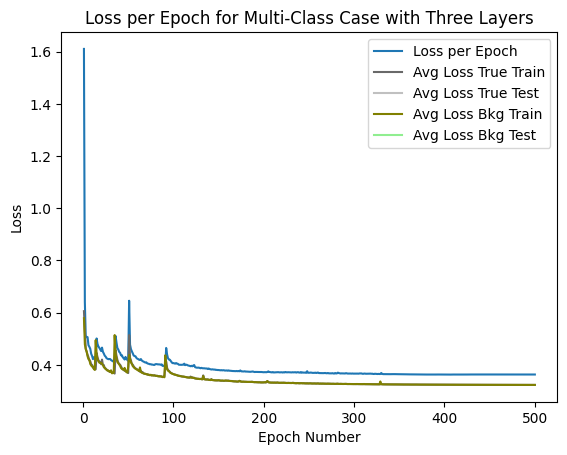

In [75]:
plt.plot(epoch_number, loss_per_epoch, label='Loss per Epoch')
plt.plot(epoch_number, avg_loss_training_true_class,
         'dimgray', label='Avg Loss True Train')
plt.plot(epoch_number, avg_loss_testing_true_class,
         'silver', label='Avg Loss True Test')
plt.plot(epoch_number, avg_loss_training_bkg_classes,
         'olive', label='Avg Loss Bkg Train')
plt.plot(epoch_number, avg_loss_testing_bkg_classes,
         'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Loss per Epoch for Multi-Class Case with Three Layers")
plt.legend()
plt.show()

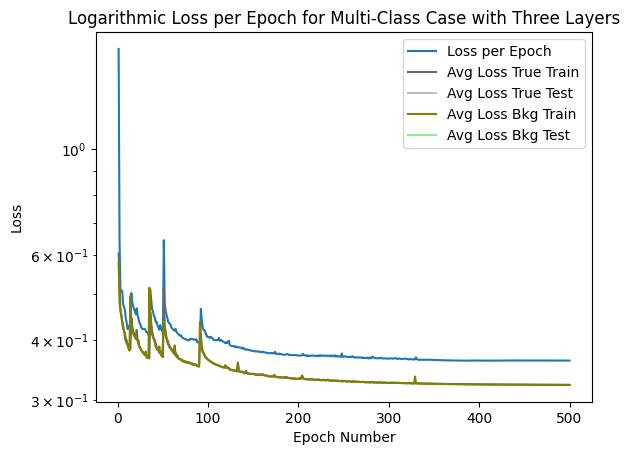

In [76]:
plt.plot(epoch_number, loss_per_epoch, label='Loss per Epoch')
plt.plot(epoch_number, avg_loss_training_true_class,
         'dimgray', label='Avg Loss True Train')
plt.plot(epoch_number, avg_loss_testing_true_class,
         'silver', label='Avg Loss True Test')
plt.plot(epoch_number, avg_loss_training_bkg_classes,
         'olive', label='Avg Loss Bkg Train')
plt.plot(epoch_number, avg_loss_testing_bkg_classes,
         'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Logarithmic Loss per Epoch for Multi-Class Case with Three Layers")
plt.legend()
plt.show()

In [77]:
def plotROCCurve(epoch_scores, epoch_truth_labels, epoch_number):
    # Generate binary labels where 1 represents the true class (class 1), and 0 represents all background classes (0, 2, 3, 4)
    binary_labels = (epoch_truth_labels == 1).astype(int)

    # Extract scores for the true class (first column in `epoch_scores`, class 1)
    true_class_scores = epoch_scores[:, 0]

    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(binary_labels, true_class_scores)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.3f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Epoch " + str(epoch_number))
    plt.show()

In [78]:
# Epoch numbers for plot labels
epoch_number = list(range(1, len(loss_per_epoch) + 1))

# Define custom class labels with the new mapping
class_labels = ["Lone-Lone", "True Cluster",
                "Lone-Cluster", "Cluster-Lone", "Cluster-Cluster"]
class_order = [0, 1, 2, 3, 4]

# Function to plot ROC curve for multiclass classification with custom labels


def plotROCCurveMulticlass(epoch_scores, epoch_truth_labels, epoch_number, num_classes=5):
    plt.figure()

    # Iterate over each class in the custom order and compute the ROC curve
    for plot_idx, class_index in enumerate(class_order):
        # Convert truth labels to one-vs-all format (1 for current class, 0 for all others)
        binary_truth_labels = (epoch_truth_labels == class_index).astype(int)

        # Get the predicted probabilities/scores for the current class
        # scores for the current class
        class_scores = epoch_scores[:, class_index]

        # Compute the ROC curve
        fpr, tpr, _ = roc_curve(binary_truth_labels, class_scores)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current class with a custom label
        plt.plot(
            fpr, tpr, label=f'{class_labels[plot_idx]} (AUC = {roc_auc:.3f})')

    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for Epoch {epoch_number}")
    plt.show()

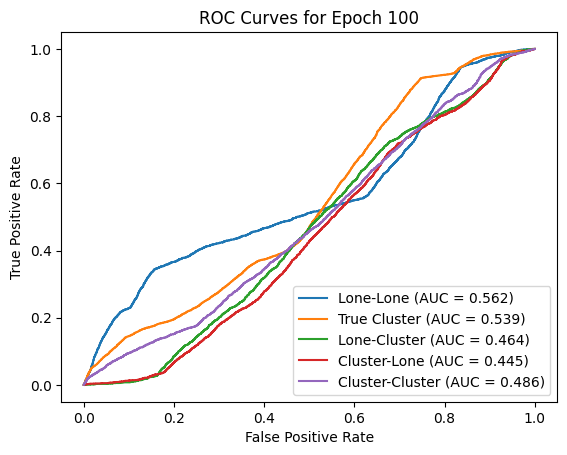

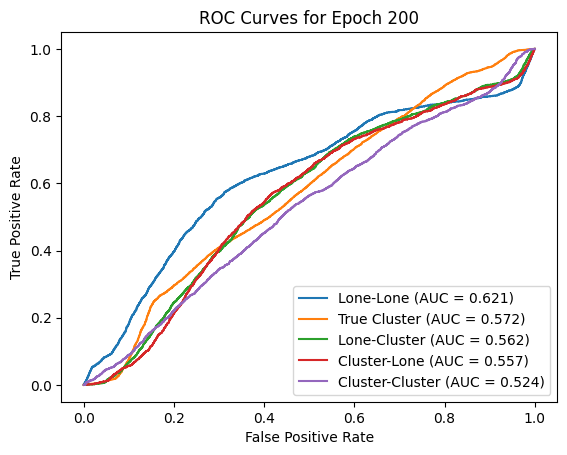

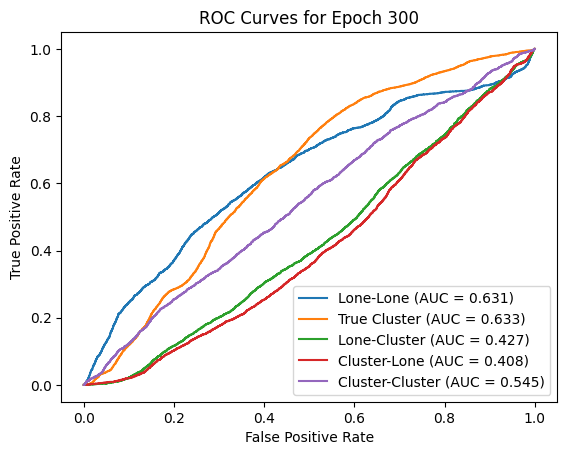

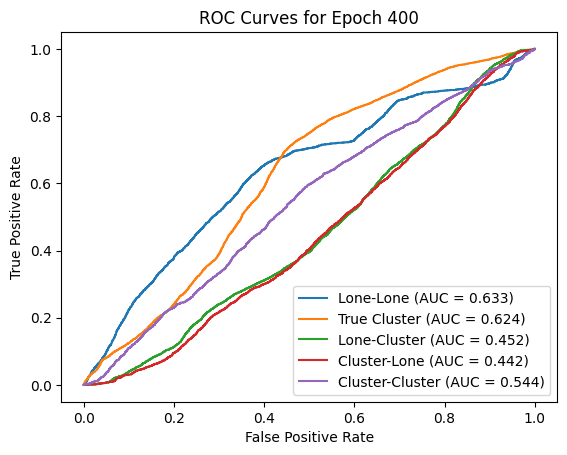

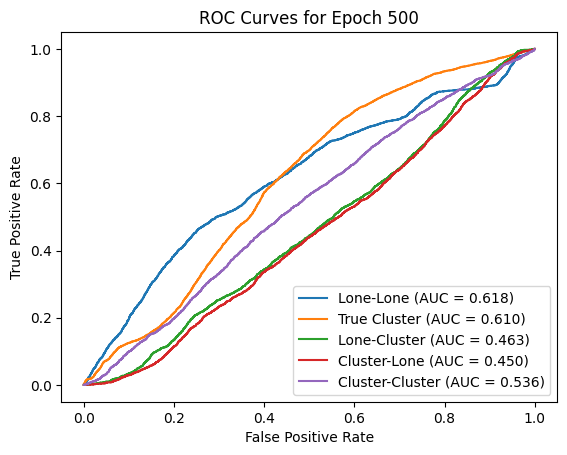

In [79]:
# Total number of epochs
epochNum = 1000
intervalShowingROCGraph = epochNum // 10  # every 100 epochs

# Plot ROC curves at specific intervals with custom labels
for i in range(0, epochNum//2):
    if (i+1) % intervalShowingROCGraph == 0:
        plotROCCurveMulticlass(scores[i], truth_labels[i], i+1)

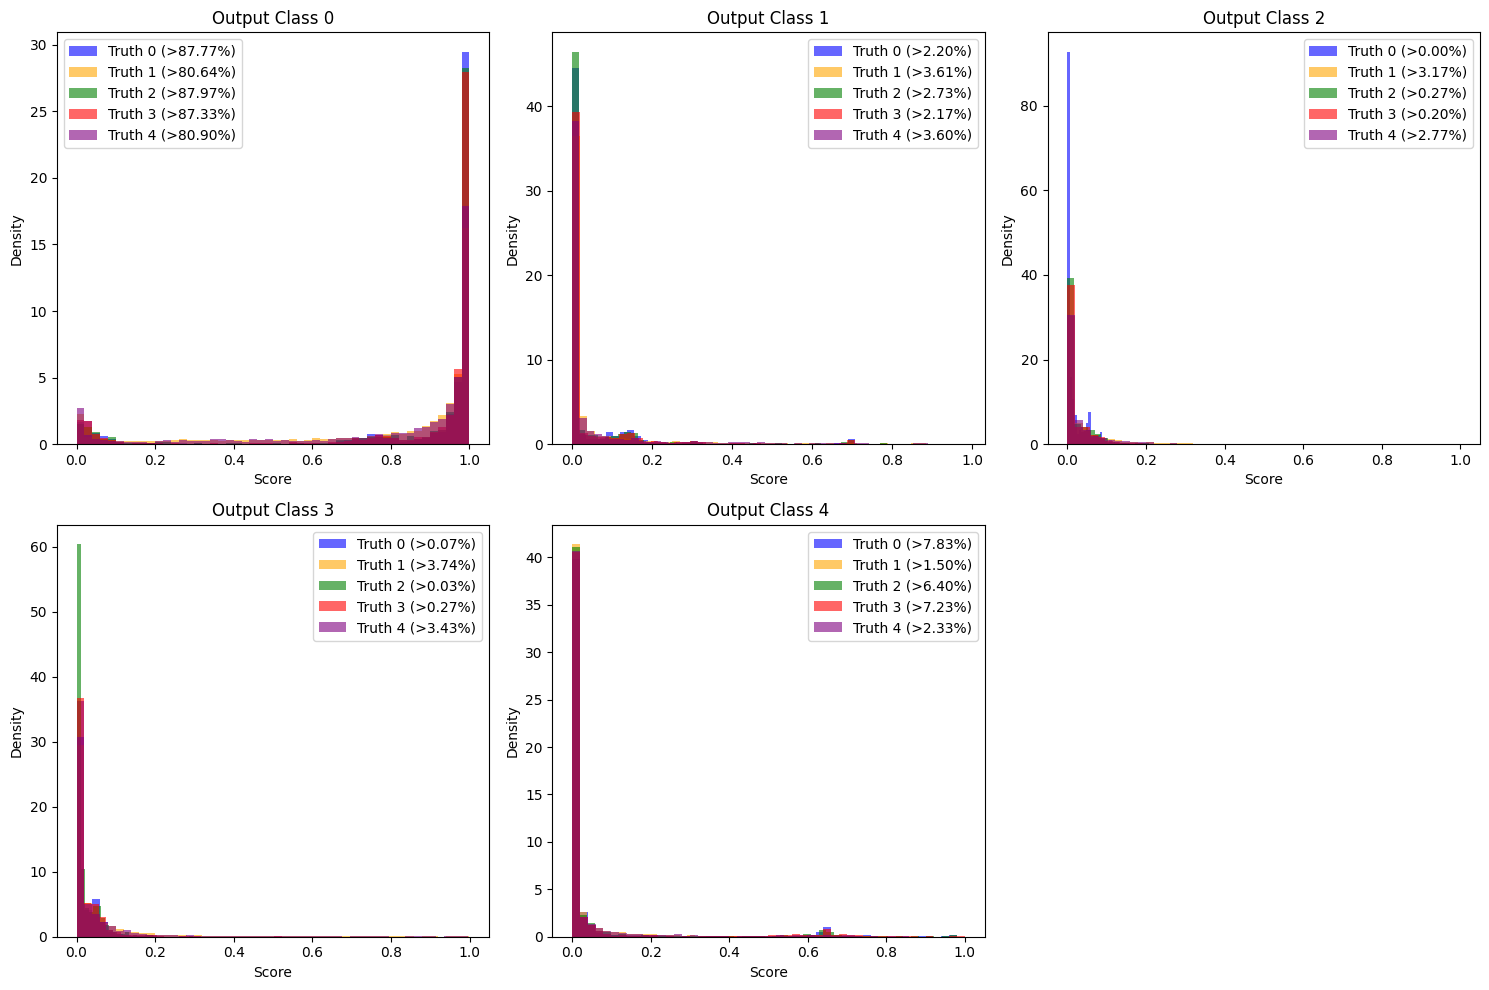

In [80]:
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple']

# We consider only the last epoch
epoch_index = -1  # Last epoch

# Extract scores and truth labels
epoch_scores = scores[epoch_index]  # Shape: (24000, 5)
epoch_truth_labels = truth_labels[epoch_index]  # Shape: (24000,)

# Create plots
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for class_idx in range(output_dim):
    ax = axes[class_idx]
    ax.set_title(f'Output Class {class_idx}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    for truth_type in sorted(np.unique(epoch_truth_labels)):
        # Get scores for the current truth type
        scores_for_truth_type = epoch_scores[epoch_truth_labels ==
                                             truth_type, class_idx]

        # Calculate the fraction of samples with scores > 0.5
        fraction_above_0_5 = np.mean(scores_for_truth_type > 0.5)

        # Plot normalized histogram
        ax.hist(
            scores_for_truth_type,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Truth {truth_type} (>{fraction_above_0_5:.2%})',
            color=colors[truth_type % len(colors)]
        )

    ax.legend()

# Hide the third column in the second row
if len(axes) > output_dim:  # Extra axes need to be hidden
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

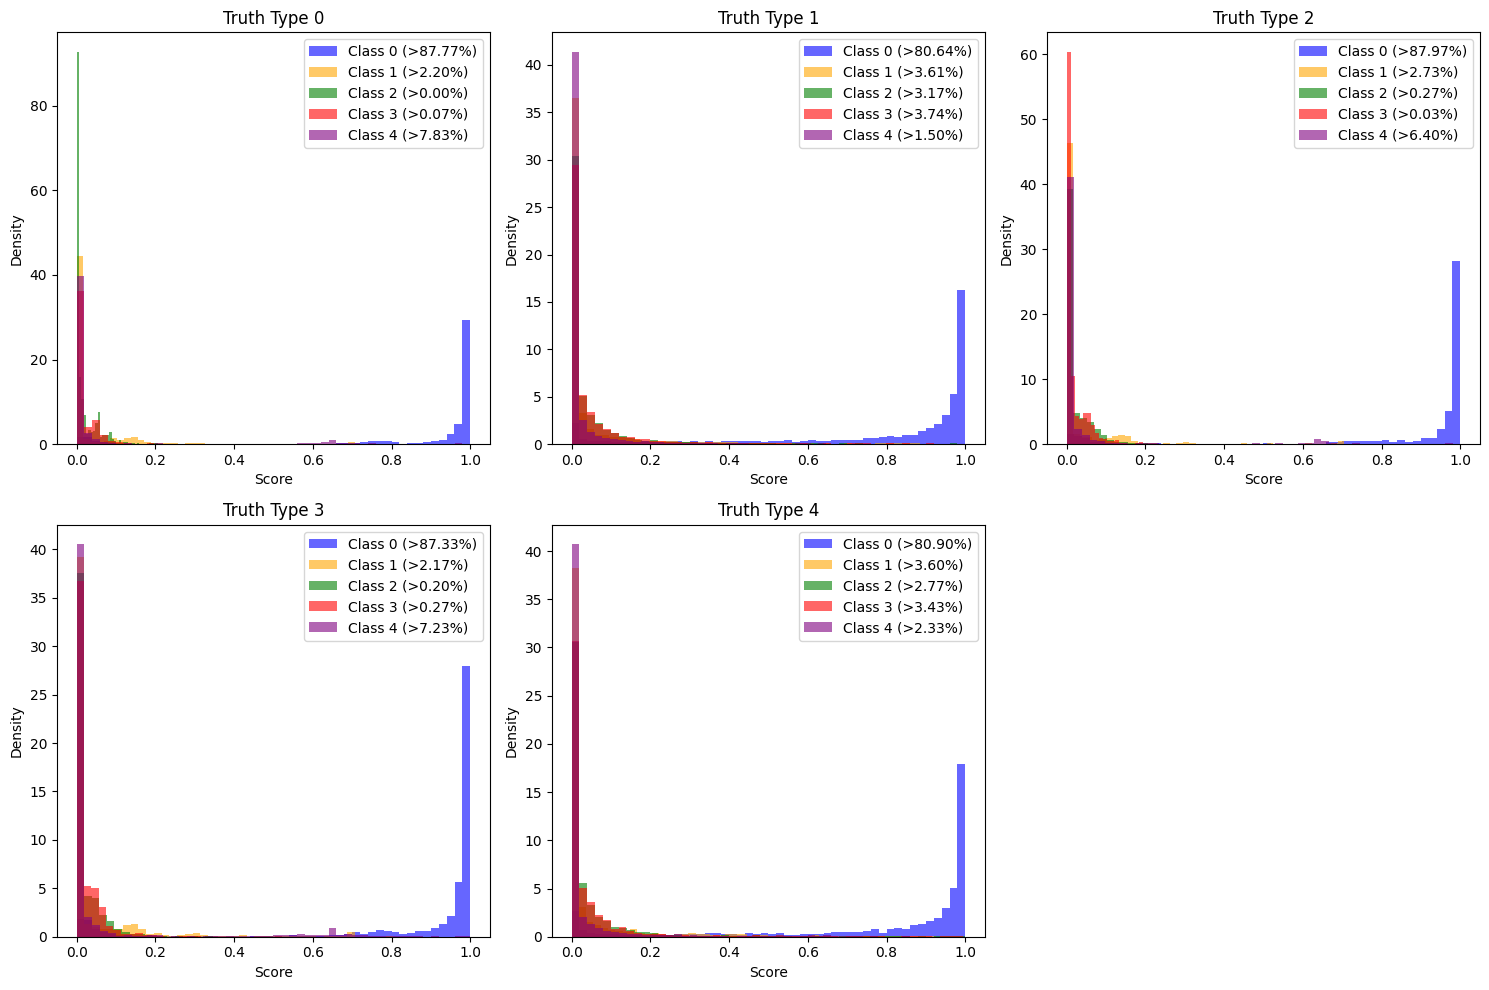

In [81]:
# Unique output classes (5 in total)
output_classes = np.arange(5)  # Classes 0, 1, 2, 3, 4

# Create plots (one for each truth type)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

unique_truth_types = sorted(np.unique(truth_labels))

# Handle cases where only one truth type is present
if len(unique_truth_types) == 1:
    axes = [axes]

for truth_type_idx, truth_type in enumerate(unique_truth_types):
    ax = axes[truth_type_idx]
    ax.set_title(f'Truth Type {truth_type}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    for class_idx in output_classes:
        # Get scores for the current output class and the current truth type
        scores_for_truth_type_class = epoch_scores[epoch_truth_labels ==
                                                   truth_type, class_idx]

        # Calculate the fraction of scores > 0.5
        fraction_above_0_5 = np.mean(scores_for_truth_type_class > 0.5)

        # Plot normalized histogram for the current output class
        ax.hist(
            scores_for_truth_type_class,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Class {class_idx} (>{fraction_above_0_5:.2%})',
            color=colors[class_idx % len(colors)]
        )

    # Add legend with updated labels
    ax.legend()

# Remove unused subplots
for idx in range(len(unique_truth_types), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()